In [12]:
import sys
import time
from nilearn import datasets
from nilearn.plotting import show

sys.stderr.write("Fetching dataset...")
t0 = time.time()

miyawaki_dataset = datasets.fetch_miyawaki2008()

# print basic information on the dataset
print(
    "First functional nifti image (4D) is located "
    f"at: {miyawaki_dataset.func[0]}"
)

X_random_filenames = miyawaki_dataset.func[12:]
X_figure_filenames = miyawaki_dataset.func[:12]
y_random_filenames = miyawaki_dataset.label[12:]
y_figure_filenames = miyawaki_dataset.label[:12]
y_shape = (10, 10)

sys.stderr.write(f" Done ({time.time() - t0:.2f}s).\n")


Fetching dataset...

[get_dataset_dir] Dataset found in /Users/sreeku/nilearn_data/miyawaki2008

First functional nifti image (4D) is located at: /Users/sreeku/nilearn_data/miyawaki2008/func/data_figure_run01.nii.gz


 Done (0.06s).


15

In [13]:
import numpy as np

from nilearn.maskers import MultiNiftiMasker

sys.stderr.write("Preprocessing data...")
t0 = time.time()

# Load and mask fMRI data
masker = MultiNiftiMasker(
    mask_img=miyawaki_dataset.mask, detrend=True, standardize=False, n_jobs=2
)
masker.fit()
X_train = masker.transform(X_random_filenames)
X_test = masker.transform(X_figure_filenames)

y_train = [
    np.reshape(
        np.loadtxt(y, dtype=int, delimiter=","), (-1, *y_shape), order="F"
    )
    for y in y_random_filenames
]
y_test = [
    np.reshape(
        np.loadtxt(y, dtype=int, delimiter=","), (-1, *y_shape), order="F"
    )
    for y in y_figure_filenames
]
X_train = np.vstack([x[2:] for x in X_train])
y_train = np.vstack([y[:-2] for y in y_train]).astype(float)
X_test = np.vstack([x[2:] for x in X_test])
y_test = np.vstack([y[:-2] for y in y_test]).astype(float)

n_features = X_train.shape[1]


def flatten(list_of_2d_array):
    flattened = [array.ravel() for array in list_of_2d_array]
    return flattened


# Build the design matrix for multiscale computation
# Matrix is squared, y_rows == y_cols
y_cols = y_shape[1]

# Original data
design_matrix = np.eye(100)

# Example of matrix used for multiscale (sum pixels vertically)
#
# 0.50 *
#
# 1 1 0 0 0 0 0 0 0 0
# 0 1 1 0 0 0 0 0 0 0
# 0 0 1 1 0 0 0 0 0 0
# 0 0 0 1 1 0 0 0 0 0
# 0 0 0 0 1 1 0 0 0 0
# 0 0 0 0 0 1 1 0 0 0
# 0 0 0 0 0 0 1 1 0 0
# 0 0 0 0 0 0 0 1 1 0
# 0 0 0 0 0 0 0 0 1 1

height_tf = (np.eye(y_cols) + np.eye(y_cols, k=1))[: y_cols - 1] * 0.5
width_tf = height_tf.T

yt_tall = [np.dot(height_tf, m) for m in y_train]
yt_large = [np.dot(m, width_tf) for m in y_train]
yt_big = [np.dot(height_tf, np.dot(m, width_tf)) for m in y_train]

# Add it to the training set
y_train = [
    np.r_[y.ravel(), t.ravel(), l.ravel(), b.ravel()]
    for y, t, l, b in zip(y_train, yt_tall, yt_large, yt_big)
]

y_test = np.asarray(flatten(y_test))
y_train = np.asarray(y_train)

# Remove rest period
X_train = X_train[y_train[:, 0] != -1]
y_train = y_train[y_train[:, 0] != -1]
X_test = X_test[y_test[:, 0] != -1]
y_test = y_test[y_test[:, 0] != -1]

sys.stderr.write(f" Done ({time.time() - t0:.2f}s).\n")

Preprocessing data...

[MultiNiftiMasker.fit] Resampling mask

 Done (24.51s).


16

In [14]:
sys.stderr.write("Training classifiers... \r")
t0 = time.time()

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create as many OrthogonalMatchingPursuit as voxels to predict
clfs = []
n_clfs = y_train.shape[1]
for i in range(y_train.shape[1]):
    sys.stderr.write(
        f"Training classifiers {int(i + 1):03}/{int(n_clfs)}... \r"
    )

    clf = Pipeline(
        [
            ("selection", SelectKBest(f_classif, k=500)),
            ("scl", StandardScaler()),
            ("clf", OrthogonalMatchingPursuit(n_nonzero_coefs=10)),
        ]
    )
    clf.fit(X_train, y_train[:, i])
    clfs.append(clf)

sys.stderr.write(
    f"Training classifiers {n_clfs:03d}/{n_clfs:d}... "
    f"Done ({(time.time() - t0):.2f}s).\n"
)

Training classifiers 361/361... Done (24.40s).


47

In [15]:
sys.stderr.write("Calculating scores and outputs...")
t0 = time.time()

y_pred = [clf.predict(X_test) for clf in clfs]
y_pred = np.asarray(y_pred).T


# We need to the multi scale reconstruction
def split_multi_scale(y, y_shape):
    """Split data into 4 original multi_scale images"""
    yw, yh = y_shape

    # Index of original image
    split_index = [yw * yh]
    # Index of large image
    split_index.append(split_index[-1] + (yw - 1) * yh)
    # Index of tall image
    split_index.append(split_index[-1] + yw * (yh - 1))
    # Index of big image
    split_index.append(split_index[-1] + (yw - 1) * (yh - 1))

    # We split according to computed indices
    y_preds = np.split(y, split_index, axis=1)

    # y_pred is the original image
    y_pred = y_preds[0]

    # y_pred_tall is the image with 1x2 patch application. We have to make
    # some calculus to get it back in original shape
    height_tf_i = (np.eye(y_cols) + np.eye(y_cols, k=-1))[
        :, : y_cols - 1
    ] * 0.5
    height_tf_i.flat[0] = 1
    height_tf_i.flat[-1] = 1
    y_pred_tall = [
        np.dot(height_tf_i, np.reshape(m, (yw - 1, yh))).flatten()
        for m in y_preds[1]
    ]
    y_pred_tall = np.asarray(y_pred_tall)

    # y_pred_large is the image with 2x1 patch application. We have to make
    # some calculus to get it back in original shape
    width_tf_i = (np.eye(y_cols) + np.eye(y_cols, k=1))[: y_cols - 1] * 0.5
    width_tf_i.flat[0] = 1
    width_tf_i.flat[-1] = 1
    y_pred_large = [
        np.dot(np.reshape(m, (yw, yh - 1)), width_tf_i).flatten()
        for m in y_preds[2]
    ]
    y_pred_large = np.asarray(y_pred_large)

    # y_pred_big is the image with 2x2 patch application. We use previous
    # matrices to get it back in original shape
    y_pred_big = [
        np.dot(np.reshape(m, (yw - 1, yh - 1)), width_tf_i) for m in y_preds[3]
    ]
    y_pred_big = [
        np.dot(height_tf_i, np.reshape(m, (yw - 1, yh))).flatten()
        for m in y_pred_big
    ]
    y_pred_big = np.asarray(y_pred_big)

    return (y_pred, y_pred_tall, y_pred_large, y_pred_big)


y_pred, y_pred_tall, y_pred_large, y_pred_big = split_multi_scale(
    y_pred, y_shape
)

y_pred = (
    0.25 * y_pred
    + 0.25 * y_pred_tall
    + 0.25 * y_pred_large
    + 0.25 * y_pred_big
)

sys.stderr.write(f" Done ({time.time() - t0:.2f}s).\n")

Calculating scores and outputs... Done (2.26s).


15

In [16]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

print("Scores")
print("------")
accuracy_to_print = np.mean(
    [accuracy_score(y_test[:, i], y_pred[:, i] > 0.5) for i in range(100)]
)
print(f"  - Accuracy (percent): {accuracy_to_print:f}")

precision_to_print = np.mean(
    [precision_score(y_test[:, i], y_pred[:, i] > 0.5) for i in range(100)]
)
print(f"  - Precision: {precision_to_print:f}")

recall_to_print = np.mean(
    [
        recall_score(y_test[:, i], y_pred[:, i] > 0.5, zero_division=0)
        for i in range(100)
    ]
)
print(f"  - Recall: {recall_to_print:f}")

f1_score_to_print = np.mean(
    [f1_score(y_test[:, i], y_pred[:, i] > 0.5) for i in range(100)]
)
print(f"  - F1-score: {f1_score_to_print:f}")

Scores
------
  - Accuracy (percent): 0.801208
  - Precision: 0.413969
  - Recall: 0.572388
  - F1-score: 0.465973


Output will be saved to: /Users/sreeku/Desktop/scikit + nilearn practice/results/plot_miyawaki_reconstruction


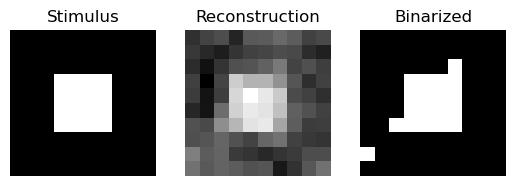

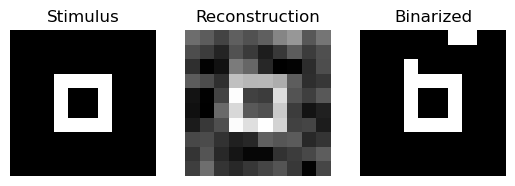

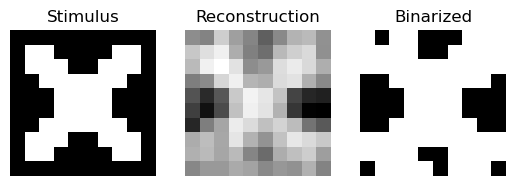

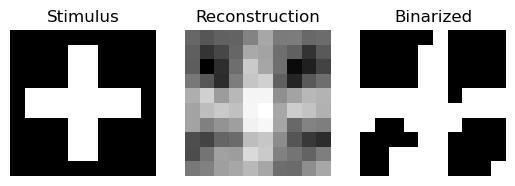

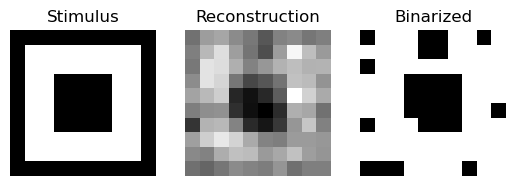

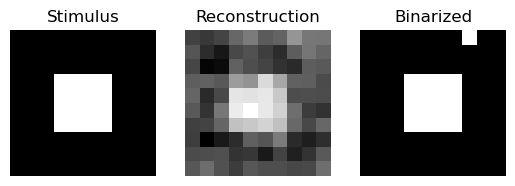

In [17]:
from pathlib import Path

from matplotlib import pyplot as plt

output_dir = Path.cwd() / "results" / "plot_miyawaki_reconstruction"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

for i in range(6):
    j = 10 * i
    fig = plt.figure()
    sp1 = plt.subplot(131)
    sp1.axis("off")
    plt.title("Stimulus")
    sp2 = plt.subplot(132)
    sp2.axis("off")
    plt.title("Reconstruction")
    sp3 = plt.subplot(133)
    sp3.axis("off")
    plt.title("Binarized")
    sp1.imshow(
        np.reshape(y_test[j], (10, 10)),
        cmap=plt.cm.gray,
        interpolation="nearest",
    )
    sp2.imshow(
        np.reshape(y_pred[j], (10, 10)),
        cmap=plt.cm.gray,
        interpolation="nearest",
    )
    sp3.imshow(
        np.reshape(y_pred[j] > 0.5, (10, 10)),
        cmap=plt.cm.gray,
        interpolation="nearest",
    )
    plt.savefig(output_dir / f"miyawaki2008_reconstruction_{int(i)}.png")

show()